# Reverse MNIST

The goal of this model is to run the MNIST dataset in reverse: using a GAN, input a digit between 0 and 9, and receive an output 28 \* 28 image array. See: https://keras.io/examples/generative/conditional_gan/

In [3]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, Concatenate, UpSampling2D, Conv2D, LeakyReLU, multiply
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
import tensorflow as tf
import matplotlib.pyplot as plt

import numpy as np

In [3]:
(X_train, y_train), (_, _) = mnist.load_data()

In [4]:
# Image shape information
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
if len(X_train.shape) == 4:
    channels = X_train.shape[3]
else:
    channels = 1
img_shape = (img_rows, img_cols, channels)
num_classes = 10
latent_dim = 100
optimizer = Adam(0.0002, 0.5)

In [5]:
def generator():
    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label))

    model_input = multiply([noise, label_embedding])
    img = model(model_input)

    return Model([noise, label], img)

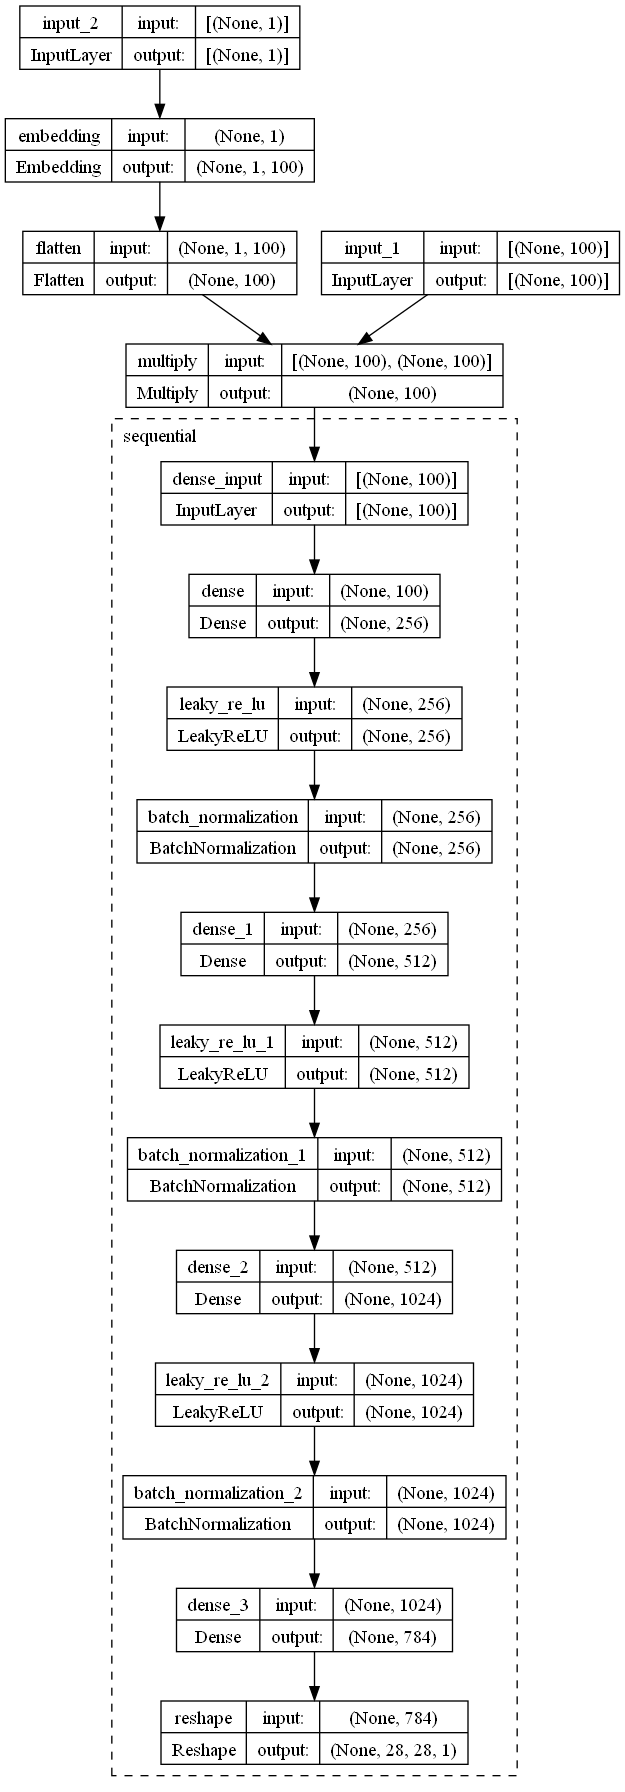

In [9]:
tf.keras.utils.plot_model(generator, show_shapes=True, expand_nested=True)

In [14]:
def discriminator():

    model = Sequential()

    model.add(Dense(512, input_dim=np.prod(img_shape)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    label = Input(shape=(1,), dtype='int32')

    label_embedding = Flatten()(Embedding(num_classes, np.prod(img_shape))(label))
    flat_img = Flatten()(img)

    model_input = multiply([flat_img, label_embedding])

    validity = model(model_input)

    return Model([img, label], validity)

In [15]:
# Build and compile the discriminator
discriminator = discriminator()
discriminator.compile(loss=['binary_crossentropy'], optimizer=optimizer, metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 512)              

In [16]:
# Build the generator
generator = generator()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_10 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                      

In [17]:
# The generator takes noise and the target label as input
# and generates the corresponding digit of that label
noise = Input(shape=(latent_dim,))
label = Input(shape=(1,))
img = generator([noise, label])

In [18]:
# For the combined model we will only train the generator
discriminator.trainable = False

In [19]:
# The discriminator takes generated image as input and determines validity
# and the label of that image
valid = discriminator([img, label])

In [20]:
# The combined model  (stacked generator and discriminator)
# Trains generator to fool discriminator
combined = Model([noise, label], valid)
combined.compile(loss=['binary_crossentropy'], optimizer=optimizer)

In [21]:
#Function which save the generated 10 digits after every 'sample_interval'(here 200) number of epochs
def sample_images(epoch):
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    sampled_labels = np.arange(0, 10).reshape(-1, 1)

    gen_imgs = generator.predict([noise, sampled_labels])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
            axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("generated/%d.png" % epoch)
    plt.close()

epochs=20000
batch_size=32
sample_interval=200

In [22]:
# Training both Discriminator and Generator

# Configure input
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)
y_train = y_train.reshape(-1, 1)
    
# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

In [25]:
for epoch in range(epochs):

    #Training the Discriminator

    # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs, labels = X_train[idx], y_train[idx]

    # Sample noise as generator input
    noise = np.random.normal(0, 1, (batch_size, 100))

    # Generate a half batch of new images
    gen_imgs = generator.predict([noise, labels])

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch([imgs, labels], valid)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    #Training the Generator

    # Condition on labels
    sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

    # Train the generator
    g_loss = combined.train_on_batch([noise, sampled_labels], valid)
    
    # Plot the progress every 100 epochs
    if epoch % 100 == 0:
        print ("%d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, epochs, d_loss[0], 100*d_loss[1], g_loss))

    # Saving generated image samples at every sample interval
    if epoch % sample_interval == 0:
        sample_images(epoch)

1/1 [==============================] - 0s 21ms/step
0/20000 [D loss: 0.678802, acc.: 50.00%] [G loss: 0.667698]
1/1 [==============================] - 0s 19ms/step
100/20000 [D loss: 0.411333, acc.: 81.25%] [G loss: 7.195852]
1/1 [==============================] - 0s 21ms/step
200/20000 [D loss: 0.290844, acc.: 87.50%] [G loss: 3.710632]
1/1 [==============================] - 0s 24ms/step
300/20000 [D loss: 0.284476, acc.: 93.75%] [G loss: 2.446478]
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 20ms/step
400/20000 [D loss: 0.485007, acc.: 71.88%] [G loss: 1.701978]
1/1 [==============================] - 0s 20ms/step
500/20000 [D loss: 0.487871, acc.: 71.88%] [G loss: 1.651168]
1/1 [==============================] - 0s 20ms/step
600/20000 [D loss: 0.375215, acc.: 85.94%] [G loss: 2.058796]
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step
700/20000 [D loss: 0.518305, acc.: 75.00%] [G loss: 2.046359]
1/1 [==============================] - 0s 20ms/step
800/20000 [D loss: 0.539667, acc.: 81.25%] [G loss: 1.577448]
1/1 [==============================] - 0s 26ms/step
900/20000 [D loss: 0.655317, acc.: 62.50%] [G loss: 1.669307]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step
1000/20000 [D loss: 0.543153, acc.: 71.88%] [G loss: 1.417217]
1/1 [==============================] - 0s 20ms/step
1100/20000 [D loss: 0.515712, acc.: 73.44%] [G loss: 1.263845]
1/1 [==============================] - 0s 20ms/step
1200/20000 [D loss: 0.621160, acc.: 64.06%] [G loss: 1.274059]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step
1300/20000 [D loss: 0.661872, acc.: 54.69%] [G loss: 1.238734]
1/1 [==============================] - 0s 20ms/step
1400/20000 [D loss: 0.603690, acc.: 64.06%] [G loss: 1.221348]
1/1 [==============================] - 0s 20ms/step
1500/20000 [D loss: 0.621741, acc.: 56.25%] [G loss: 1.022957]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step
1600/20000 [D loss: 0.624915, acc.: 67.19%] [G loss: 1.124919]
1/1 [==============================] - 0s 21ms/step
1700/20000 [D loss: 0.648322, acc.: 60.94%] [G loss: 0.962898]


1/1 [==============================] - 0s 19ms/step
1800/20000 [D loss: 0.597618, acc.: 67.19%] [G loss: 0.991820]
1/1 [==============================] - 0s 21ms/step
1900/20000 [D loss: 0.639649, acc.: 67.19%] [G loss: 0.912976]
1/1 [==============================] - 0s 20ms/step
2000/20000 [D loss: 0.604772, acc.: 67.19%] [G loss: 0.904453]
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step
2100/20000 [D loss: 0.659956, acc.: 56.25%] [G loss: 0.861053]
1/1 [==============================] - 0s 21ms/step
2200/20000 [D loss: 0.637575, acc.: 67.19%] [G loss: 0.898222]
1/1 [==============================] - 0s 21ms/step
2300/20000 [D loss: 0.686440, acc.: 56.25%] [G loss: 0.802734]
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step
2400/20000 [D loss: 0.666314, acc.: 60.94%] [G loss: 0.828516]
1/1 [==============================] - 0s 19ms/step
2500/20000 [D loss: 0.691599, acc.: 59.38%] [G loss: 0.830463]
1/1 [==============================] - 0s 20ms/step
2600/20000 [D loss: 0.689129, acc.: 53.12%] [G loss: 0.850742]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step
2700/20000 [D loss: 0.656553, acc.: 60.94%] [G loss: 0.841772]
1/1 [==============================] - 0s 19ms/step
2800/20000 [D loss: 0.694383, acc.: 54.69%] [G loss: 0.833851]
1/1 [==============================] - 0s 20ms/step
2900/20000 [D loss: 0.653487, acc.: 56.25%] [G loss: 0.850725]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step
3000/20000 [D loss: 0.665680, acc.: 60.94%] [G loss: 0.779802]
1/1 [==============================] - 0s 20ms/step
3100/20000 [D loss: 0.693160, acc.: 57.81%] [G loss: 0.886752]
1/1 [==============================] - 0s 20ms/step
3200/20000 [D loss: 0.618033, acc.: 67.19%] [G loss: 0.834092]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step
3300/20000 [D loss: 0.683120, acc.: 48.44%] [G loss: 0.751250]
1/1 [==============================] - 0s 24ms/step
3400/20000 [D loss: 0.726237, acc.: 43.75%] [G loss: 0.768507]
1/1 [==============================] - 0s 20ms/step
3500/20000 [D loss: 0.684953, acc.: 54.69%] [G loss: 0.737448]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step
3600/20000 [D loss: 0.658201, acc.: 51.56%] [G loss: 0.843574]
1/1 [==============================] - 0s 19ms/step
3700/20000 [D loss: 0.669362, acc.: 56.25%] [G loss: 0.778321]
1/1 [==============================] - 0s 21ms/step
3800/20000 [D loss: 0.718416, acc.: 46.88%] [G loss: 0.802216]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step
3900/20000 [D loss: 0.675957, acc.: 50.00%] [G loss: 0.792019]
1/1 [==============================] - 0s 20ms/step
4000/20000 [D loss: 0.654656, acc.: 51.56%] [G loss: 0.736443]
1/1 [==============================] - 0s 19ms/step
4100/20000 [D loss: 0.697903, acc.: 46.88%] [G loss: 0.794293]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step
4200/20000 [D loss: 0.665584, acc.: 53.12%] [G loss: 0.790715]
1/1 [==============================] - 0s 20ms/step
4300/20000 [D loss: 0.657263, acc.: 53.12%] [G loss: 0.736037]
1/1 [==============================] - 0s 19ms/step
4400/20000 [D loss: 0.696483, acc.: 51.56%] [G loss: 0.786143]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step
4500/20000 [D loss: 0.659672, acc.: 59.38%] [G loss: 0.821323]
1/1 [==============================] - 0s 19ms/step
4600/20000 [D loss: 0.711194, acc.: 48.44%] [G loss: 0.796088]
1/1 [==============================] - 0s 19ms/step
4700/20000 [D loss: 0.658317, acc.: 64.06%] [G loss: 0.708774]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step
4800/20000 [D loss: 0.698139, acc.: 56.25%] [G loss: 0.838420]
1/1 [==============================] - 0s 21ms/step
4900/20000 [D loss: 0.646539, acc.: 57.81%] [G loss: 0.783822]
1/1 [==============================] - 0s 20ms/step
5000/20000 [D loss: 0.667412, acc.: 54.69%] [G loss: 0.795380]
1/1 [==============================] - 0s 20ms/step
5100/20000 [D loss: 0.692504, acc.: 46.88%] [G loss: 0.705386]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step
5200/20000 [D loss: 0.689684, acc.: 57.81%] [G loss: 0.762456]
1/1 [==============================] - 0s 21ms/step
5300/20000 [D loss: 0.673880, acc.: 56.25%] [G loss: 0.731507]
1/1 [==============================] - 0s 19ms/step
5400/20000 [D loss: 0.656540, acc.: 64.06%] [G loss: 0.783160]
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step
5500/20000 [D loss: 0.669348, acc.: 46.88%] [G loss: 0.793615]
1/1 [==============================] - 0s 20ms/step
5600/20000 [D loss: 0.673865, acc.: 50.00%] [G loss: 0.750021]
1/1 [==============================] - 0s 20ms/step
5700/20000 [D loss: 0.673818, acc.: 60.94%] [G loss: 0.757086]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step
5800/20000 [D loss: 0.677628, acc.: 59.38%] [G loss: 0.794731]
1/1 [==============================] - 0s 23ms/step
5900/20000 [D loss: 0.710493, acc.: 54.69%] [G loss: 0.776977]
1/1 [==============================] - 0s 21ms/step
6000/20000 [D loss: 0.664521, acc.: 64.06%] [G loss: 0.765621]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step
6100/20000 [D loss: 0.665850, acc.: 60.94%] [G loss: 0.741125]
1/1 [==============================] - 0s 18ms/step
6200/20000 [D loss: 0.670219, acc.: 56.25%] [G loss: 0.818891]
1/1 [==============================] - 0s 21ms/step
6300/20000 [D loss: 0.646365, acc.: 64.06%] [G loss: 0.766669]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step
6400/20000 [D loss: 0.648838, acc.: 64.06%] [G loss: 0.759572]
1/1 [==============================] - 0s 23ms/step
6500/20000 [D loss: 0.672750, acc.: 59.38%] [G loss: 0.767072]
1/1 [==============================] - 0s 20ms/step
6600/20000 [D loss: 0.617157, acc.: 62.50%] [G loss: 0.771112]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step
6700/20000 [D loss: 0.651560, acc.: 64.06%] [G loss: 0.801892]
1/1 [==============================] - 0s 20ms/step
6800/20000 [D loss: 0.699864, acc.: 54.69%] [G loss: 0.802549]
1/1 [==============================] - 0s 20ms/step
6900/20000 [D loss: 0.678914, acc.: 54.69%] [G loss: 0.752963]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step
7000/20000 [D loss: 0.672388, acc.: 56.25%] [G loss: 0.789859]
1/1 [==============================] - 0s 20ms/step
7100/20000 [D loss: 0.690586, acc.: 53.12%] [G loss: 0.794927]
1/1 [==============================] - 0s 66ms/step
7200/20000 [D loss: 0.670513, acc.: 60.94%] [G loss: 0.846083]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step
7300/20000 [D loss: 0.680410, acc.: 50.00%] [G loss: 0.783819]
1/1 [==============================] - 0s 20ms/step
7400/20000 [D loss: 0.711304, acc.: 53.12%] [G loss: 0.823125]
1/1 [==============================] - 0s 20ms/step
7500/20000 [D loss: 0.699602, acc.: 54.69%] [G loss: 0.809371]
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step
7600/20000 [D loss: 0.667854, acc.: 64.06%] [G loss: 0.779953]
1/1 [==============================] - 0s 19ms/step
7700/20000 [D loss: 0.684015, acc.: 62.50%] [G loss: 0.732158]
1/1 [==============================] - 0s 19ms/step
7800/20000 [D loss: 0.689878, acc.: 50.00%] [G loss: 0.838170]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step
7900/20000 [D loss: 0.658908, acc.: 54.69%] [G loss: 0.836513]
1/1 [==============================] - 0s 21ms/step
8000/20000 [D loss: 0.703587, acc.: 59.38%] [G loss: 0.789751]
1/1 [==============================] - 0s 20ms/step
8100/20000 [D loss: 0.676818, acc.: 50.00%] [G loss: 0.858467]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step
8200/20000 [D loss: 0.656841, acc.: 56.25%] [G loss: 0.823077]
1/1 [==============================] - 0s 19ms/step
8300/20000 [D loss: 0.680848, acc.: 53.12%] [G loss: 0.780585]
1/1 [==============================] - 0s 20ms/step
8400/20000 [D loss: 0.680255, acc.: 54.69%] [G loss: 0.874607]
1/1 [==============================] - 0s 21ms/step
8500/20000 [D loss: 0.653557, acc.: 60.94%] [G loss: 0.824073]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step
8600/20000 [D loss: 0.660987, acc.: 57.81%] [G loss: 0.748724]
1/1 [==============================] - 0s 19ms/step
8700/20000 [D loss: 0.664435, acc.: 60.94%] [G loss: 0.790461]
1/1 [==============================] - 0s 20ms/step
8800/20000 [D loss: 0.686349, acc.: 50.00%] [G loss: 0.792578]
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step
8900/20000 [D loss: 0.619171, acc.: 67.19%] [G loss: 0.758009]
1/1 [==============================] - 0s 20ms/step
9000/20000 [D loss: 0.690436, acc.: 54.69%] [G loss: 0.856705]
1/1 [==============================] - 0s 20ms/step
9100/20000 [D loss: 0.700691, acc.: 53.12%] [G loss: 0.855569]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step
9200/20000 [D loss: 0.669965, acc.: 53.12%] [G loss: 0.766839]
1/1 [==============================] - 0s 20ms/step
9300/20000 [D loss: 0.674034, acc.: 56.25%] [G loss: 0.788881]
1/1 [==============================] - 0s 21ms/step
9400/20000 [D loss: 0.678238, acc.: 54.69%] [G loss: 0.789757]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step
9500/20000 [D loss: 0.655447, acc.: 51.56%] [G loss: 0.787135]
1/1 [==============================] - 0s 21ms/step
9600/20000 [D loss: 0.690366, acc.: 56.25%] [G loss: 0.806837]
1/1 [==============================] - 0s 21ms/step
9700/20000 [D loss: 0.675171, acc.: 64.06%] [G loss: 0.778707]
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step
9800/20000 [D loss: 0.696544, acc.: 57.81%] [G loss: 0.805840]
1/1 [==============================] - 0s 21ms/step
9900/20000 [D loss: 0.685790, acc.: 50.00%] [G loss: 0.785359]
1/1 [==============================] - 0s 20ms/step
10000/20000 [D loss: 0.653089, acc.: 53.12%] [G loss: 0.715167]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step
10100/20000 [D loss: 0.612996, acc.: 73.44%] [G loss: 0.776318]
1/1 [==============================] - 0s 21ms/step
10200/20000 [D loss: 0.684523, acc.: 53.12%] [G loss: 0.818429]
1/1 [==============================] - 0s 19ms/step
10300/20000 [D loss: 0.635680, acc.: 64.06%] [G loss: 0.828342]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step
10400/20000 [D loss: 0.665988, acc.: 59.38%] [G loss: 0.836214]
1/1 [==============================] - 0s 20ms/step
10500/20000 [D loss: 0.646957, acc.: 56.25%] [G loss: 0.820062]
1/1 [==============================] - 0s 21ms/step
10600/20000 [D loss: 0.726090, acc.: 45.31%] [G loss: 0.785934]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step
10700/20000 [D loss: 0.678660, acc.: 46.88%] [G loss: 0.864378]
1/1 [==============================] - 0s 20ms/step
10800/20000 [D loss: 0.646562, acc.: 65.62%] [G loss: 0.803186]
1/1 [==============================] - 0s 21ms/step
10900/20000 [D loss: 0.655629, acc.: 56.25%] [G loss: 0.795841]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step
11000/20000 [D loss: 0.661888, acc.: 60.94%] [G loss: 0.731000]
1/1 [==============================] - 0s 23ms/step
11100/20000 [D loss: 0.631145, acc.: 60.94%] [G loss: 0.841332]
1/1 [==============================] - 0s 20ms/step
11200/20000 [D loss: 0.665326, acc.: 59.38%] [G loss: 0.799393]
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step
11300/20000 [D loss: 0.663038, acc.: 57.81%] [G loss: 0.809657]
1/1 [==============================] - 0s 18ms/step
11400/20000 [D loss: 0.653114, acc.: 51.56%] [G loss: 0.844239]
1/1 [==============================] - 0s 20ms/step
11500/20000 [D loss: 0.644187, acc.: 57.81%] [G loss: 0.749962]
1/1 [==============================] - 0s 21ms/step
11600/20000 [D loss: 0.629146, acc.: 65.62%] [G loss: 0.739347]


1/1 [==============================] - 0s 21ms/step
11700/20000 [D loss: 0.645422, acc.: 57.81%] [G loss: 0.781760]
1/1 [==============================] - 0s 20ms/step
11800/20000 [D loss: 0.718746, acc.: 48.44%] [G loss: 0.808003]
1/1 [==============================] - 0s 20ms/step
11900/20000 [D loss: 0.692391, acc.: 53.12%] [G loss: 0.784045]
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 20ms/step
12000/20000 [D loss: 0.705241, acc.: 45.31%] [G loss: 0.815358]
1/1 [==============================] - 0s 20ms/step
12100/20000 [D loss: 0.662123, acc.: 60.94%] [G loss: 0.792857]
1/1 [==============================] - 0s 19ms/step
12200/20000 [D loss: 0.682715, acc.: 60.94%] [G loss: 0.783302]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step
12300/20000 [D loss: 0.669748, acc.: 54.69%] [G loss: 0.769503]
1/1 [==============================] - 0s 20ms/step
12400/20000 [D loss: 0.690510, acc.: 50.00%] [G loss: 0.784857]
1/1 [==============================] - 0s 20ms/step
12500/20000 [D loss: 0.685030, acc.: 57.81%] [G loss: 0.812356]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step
12600/20000 [D loss: 0.680537, acc.: 64.06%] [G loss: 0.730830]
1/1 [==============================] - 0s 21ms/step
12700/20000 [D loss: 0.612820, acc.: 67.19%] [G loss: 0.750647]
1/1 [==============================] - 0s 31ms/step
12800/20000 [D loss: 0.664168, acc.: 70.31%] [G loss: 0.781846]
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step
12900/20000 [D loss: 0.719230, acc.: 43.75%] [G loss: 0.818613]
1/1 [==============================] - 0s 21ms/step
13000/20000 [D loss: 0.646887, acc.: 60.94%] [G loss: 0.817581]
1/1 [==============================] - 0s 20ms/step
13100/20000 [D loss: 0.658595, acc.: 59.38%] [G loss: 0.791971]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step
13200/20000 [D loss: 0.695245, acc.: 59.38%] [G loss: 0.729785]
1/1 [==============================] - 0s 21ms/step
13300/20000 [D loss: 0.673148, acc.: 59.38%] [G loss: 0.755558]
1/1 [==============================] - 0s 25ms/step
13400/20000 [D loss: 0.653003, acc.: 56.25%] [G loss: 0.789747]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step
13500/20000 [D loss: 0.709952, acc.: 48.44%] [G loss: 0.779757]
1/1 [==============================] - 0s 20ms/step
13600/20000 [D loss: 0.688609, acc.: 46.88%] [G loss: 0.740661]
1/1 [==============================] - 0s 68ms/step
13700/20000 [D loss: 0.674832, acc.: 50.00%] [G loss: 0.798494]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step
13800/20000 [D loss: 0.693885, acc.: 56.25%] [G loss: 0.845204]
1/1 [==============================] - 0s 20ms/step
13900/20000 [D loss: 0.654684, acc.: 65.62%] [G loss: 0.785860]
1/1 [==============================] - 0s 21ms/step
14000/20000 [D loss: 0.677921, acc.: 50.00%] [G loss: 0.787290]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step
14100/20000 [D loss: 0.679388, acc.: 53.12%] [G loss: 0.799538]
1/1 [==============================] - 0s 20ms/step
14200/20000 [D loss: 0.653050, acc.: 54.69%] [G loss: 0.791053]
1/1 [==============================] - 0s 20ms/step
14300/20000 [D loss: 0.677863, acc.: 60.94%] [G loss: 0.781258]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step
14400/20000 [D loss: 0.660221, acc.: 54.69%] [G loss: 0.820341]
1/1 [==============================] - 0s 21ms/step
14500/20000 [D loss: 0.696517, acc.: 53.12%] [G loss: 0.800342]
1/1 [==============================] - 0s 20ms/step
14600/20000 [D loss: 0.665564, acc.: 51.56%] [G loss: 0.770739]
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step
14700/20000 [D loss: 0.682509, acc.: 45.31%] [G loss: 0.775976]
1/1 [==============================] - 0s 20ms/step
14800/20000 [D loss: 0.643176, acc.: 62.50%] [G loss: 0.814745]
1/1 [==============================] - 0s 21ms/step
14900/20000 [D loss: 0.712041, acc.: 51.56%] [G loss: 0.798578]
1/1 [==============================] - 0s 19ms/step
15000/20000 [D loss: 0.680982, acc.: 60.94%] [G loss: 0.833072]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step
15100/20000 [D loss: 0.644182, acc.: 60.94%] [G loss: 0.747341]
1/1 [==============================] - 0s 20ms/step
15200/20000 [D loss: 0.691201, acc.: 53.12%] [G loss: 0.808603]
1/1 [==============================] - 0s 21ms/step
15300/20000 [D loss: 0.666160, acc.: 64.06%] [G loss: 0.789668]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step
15400/20000 [D loss: 0.705603, acc.: 46.88%] [G loss: 0.824401]
1/1 [==============================] - 0s 21ms/step
15500/20000 [D loss: 0.679524, acc.: 53.12%] [G loss: 0.756858]
1/1 [==============================] - 0s 19ms/step
15600/20000 [D loss: 0.673806, acc.: 62.50%] [G loss: 0.729332]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step
15700/20000 [D loss: 0.675056, acc.: 54.69%] [G loss: 0.772262]
1/1 [==============================] - 0s 21ms/step
15800/20000 [D loss: 0.679225, acc.: 60.94%] [G loss: 0.795625]
1/1 [==============================] - 0s 20ms/step
15900/20000 [D loss: 0.685550, acc.: 56.25%] [G loss: 0.796135]
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step
16000/20000 [D loss: 0.658220, acc.: 62.50%] [G loss: 0.792576]
1/1 [==============================] - 0s 28ms/step
16100/20000 [D loss: 0.674455, acc.: 60.94%] [G loss: 0.823979]
1/1 [==============================] - 0s 19ms/step
16200/20000 [D loss: 0.664485, acc.: 64.06%] [G loss: 0.772978]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step
16300/20000 [D loss: 0.662191, acc.: 65.62%] [G loss: 0.811289]
1/1 [==============================] - 0s 21ms/step
16400/20000 [D loss: 0.675993, acc.: 50.00%] [G loss: 0.755243]
1/1 [==============================] - 0s 22ms/step
16500/20000 [D loss: 0.713188, acc.: 59.38%] [G loss: 0.790555]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step
16600/20000 [D loss: 0.677695, acc.: 56.25%] [G loss: 0.725289]
1/1 [==============================] - 0s 21ms/step
16700/20000 [D loss: 0.686861, acc.: 56.25%] [G loss: 0.771396]
1/1 [==============================] - 0s 22ms/step
16800/20000 [D loss: 0.683294, acc.: 50.00%] [G loss: 0.800453]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step
16900/20000 [D loss: 0.679720, acc.: 57.81%] [G loss: 0.795544]
1/1 [==============================] - 0s 22ms/step
17000/20000 [D loss: 0.660144, acc.: 56.25%] [G loss: 0.770664]
1/1 [==============================] - 0s 23ms/step
17100/20000 [D loss: 0.665408, acc.: 51.56%] [G loss: 0.801237]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step
17200/20000 [D loss: 0.722937, acc.: 46.88%] [G loss: 0.761959]
1/1 [==============================] - 0s 21ms/step
17300/20000 [D loss: 0.651544, acc.: 54.69%] [G loss: 0.769310]
1/1 [==============================] - 0s 20ms/step
17400/20000 [D loss: 0.669389, acc.: 57.81%] [G loss: 0.775191]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step
17500/20000 [D loss: 0.698123, acc.: 53.12%] [G loss: 0.801312]
1/1 [==============================] - 0s 21ms/step
17600/20000 [D loss: 0.667990, acc.: 62.50%] [G loss: 0.788738]
1/1 [==============================] - 0s 20ms/step
17700/20000 [D loss: 0.647455, acc.: 57.81%] [G loss: 0.809841]
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step
17800/20000 [D loss: 0.603608, acc.: 71.88%] [G loss: 0.782773]
1/1 [==============================] - 0s 20ms/step
17900/20000 [D loss: 0.661730, acc.: 59.38%] [G loss: 0.752725]
1/1 [==============================] - 0s 20ms/step
18000/20000 [D loss: 0.696154, acc.: 50.00%] [G loss: 0.766571]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step
18100/20000 [D loss: 0.673591, acc.: 57.81%] [G loss: 0.771995]
1/1 [==============================] - 0s 21ms/step
18200/20000 [D loss: 0.678484, acc.: 56.25%] [G loss: 0.757200]
1/1 [==============================] - 0s 20ms/step
18300/20000 [D loss: 0.649702, acc.: 70.31%] [G loss: 0.811001]
1/1 [==============================] - 0s 22ms/step
18400/20000 [D loss: 0.689184, acc.: 53.12%] [G loss: 0.793939]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step
18500/20000 [D loss: 0.681339, acc.: 57.81%] [G loss: 0.727316]
1/1 [==============================] - 0s 24ms/step
18600/20000 [D loss: 0.678874, acc.: 59.38%] [G loss: 0.786098]
1/1 [==============================] - 0s 21ms/step
18700/20000 [D loss: 0.643938, acc.: 68.75%] [G loss: 0.790849]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step
18800/20000 [D loss: 0.649582, acc.: 62.50%] [G loss: 0.812759]
1/1 [==============================] - 0s 26ms/step
18900/20000 [D loss: 0.704633, acc.: 46.88%] [G loss: 0.784127]
1/1 [==============================] - 0s 23ms/step
19000/20000 [D loss: 0.671013, acc.: 57.81%] [G loss: 0.781886]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step
19100/20000 [D loss: 0.669241, acc.: 56.25%] [G loss: 0.803197]
1/1 [==============================] - 0s 22ms/step
19200/20000 [D loss: 0.684395, acc.: 54.69%] [G loss: 0.778494]
1/1 [==============================] - 0s 21ms/step
19300/20000 [D loss: 0.713976, acc.: 46.88%] [G loss: 0.786732]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 25ms/step
19400/20000 [D loss: 0.688763, acc.: 51.56%] [G loss: 0.811960]
1/1 [==============================] - 0s 25ms/step
19500/20000 [D loss: 0.656523, acc.: 54.69%] [G loss: 0.774002]
1/1 [==============================] - 0s 22ms/step
19600/20000 [D loss: 0.659457, acc.: 51.56%] [G loss: 0.729810]
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step
19700/20000 [D loss: 0.668363, acc.: 60.94%] [G loss: 0.765274]
1/1 [==============================] - 0s 21ms/step
19800/20000 [D loss: 0.697102, acc.: 51.56%] [G loss: 0.774510]
1/1 [==============================] - 0s 21ms/step
19900/20000 [D loss: 0.694018, acc.: 56.25%] [G loss: 0.760005]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


In [40]:
generator.save("reverse-mnist.h5")

In [5]:
#Function which save the generated 10 digits after every 'sample_interval'(here 200) number of epochs
def predict_number(num):
    if num < 0 or num > 9:
        raise ValueError("Can only predict numbers between 0 and 9")
    noise = np.random.normal(0, 1, (1, 100))
    sampled_labels = np.array([[int(num)]])

    gen_imgs = generator.predict([noise, sampled_labels])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    plt.imshow(gen_imgs[0], cmap="gray")
    plt.show()

1/1 [==============================] - 0s 21ms/step


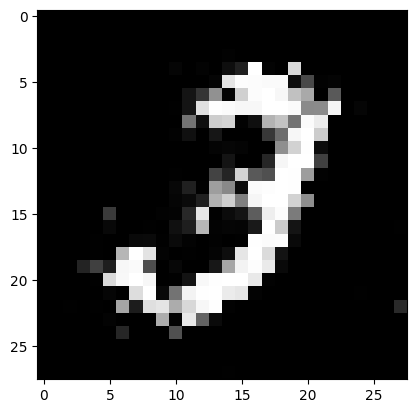

In [9]:
predict_number(3)

1/1 [==============================] - 0s 24ms/step


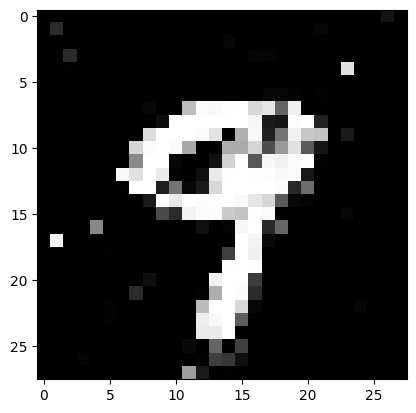

In [36]:
predict_number(9)